In [21]:
import numpy as np
import matplotlib.pyplot as plt 
from functools import reduce
from qulacs import QuantumState, QuantumCircuit
from qulacsvis import circuit_drawer
import matplotlib as mpl

mpl.rcParams.update({'font.size': 18})

# Fitting of quantum many-body dynamics

Simulation of the dynamics of a 10-spin system under the fully connected transverse Ising Hamiltonian. The following code attempts to simulate the partial dynamics of the 10-spin system using a six qubit circuit.


### Generation of teaching data

Then, we must generate teaching data to be used. In order to do this, we apply the hamiltonian given by:

$H = \sum\limits^N_{j=1} a_j X_j + \sum\limits^N_{j=1}\sum\limits^{j-1}_{k=1} J_{jk}Z_jZ_k$

corresponding to the transverse Ising Hamiltonian. Coefficients $a_j$ and $J_{jk}$ are randomly set.

The dynamics started from the initialized state $\ket{0}^{\otimes 10}$. The transient at the beginning of evolution is discarded for the duration $T_{transient} = 300$. For practical use, one can employ the dynamics obtained experimentally from a quantum system with an unknown Hamiltonian as teacher data. 

In [22]:
## seed of random number
random_seed = 0
## initialization of random number generator
np.random.seed(random_seed)
np.random.seed(0)

## Basic gate
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix() # applied to qubit 0
Z_mat = Z(0).get_matrix() # applied to qubit 0

## Function that creates fullsize gate.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    Take list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...],
    Insert Identity into unrelated qubit
    make (2**nqubit, 2**nqubit) matrix:
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## Arrange 1-qubit gates and reduce with np.kron
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## an empty site is identity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)


In [23]:
# times 
x_times = np.linspace(-1,1,100)
n_system = 10
t_transition = 300
times = 4*(x_times+1)+t_transition



In [24]:
# Define observables to be measured
from qulacs import Observable

z0 = Observable(n_system)
z0.add_operator(1.,'Z 0') # a = 1

z1 = Observable(n_system)
z1.add_operator(1.,'Z 1') # a = 1

z2 = Observable(n_system)
z2.add_operator(1.,'Z 2') # a = 1

z3 = Observable(n_system)
z3.add_operator(1.,'Z 3') # a = 1

z4 = Observable(n_system)
z4.add_operator(1.,'Z 4') # a = 1

In [25]:
from qulacs.gate import DenseMatrix

#### Create time evolution operator by making random magnetic field and random coupling Ising Hamiltonian

ham = np.zeros((2**n_system,2**n_system), dtype = complex)
for i in range(n_system): ## i runs 0 to n_system-1
    Jx = -1. + 2.*np.random.rand() ## random number in -1~1
    ham += Jx * make_fullgate( [ [i, X_mat] ], n_system)
    for j in range(i+1, n_system):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], n_system)

diag, eigen_vecs = np.linalg.eigh(ham)

z0_train_results = np.asarray([])
z1_train_results= np.asarray([])
z2_train_results = np.asarray([])
z3_train_results = np.asarray([])
z4_train_results = np.asarray([])


## Time evolution
for time_step in times:
    ## Define quantum state
    state = QuantumState(n_system)
    state.set_zero_state()
    ## Create a time evolution operator by diagonalization. H*P = P*D <-> H = P*D*P^dagger

    time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT
    time_evol_gate = DenseMatrix([i for i in range(n_system)], time_evol_op)

    # Apply time evolution operator

    time_evol_gate.update_quantum_state(state)

    z0_val = z0.get_expectation_value(state)
    z0_noise = np.random.normal(0, (z0_val**2)*0.1)
    z0_train_results = np.append(z0_train_results, z0_val+z0_noise)
    z1_val = z1.get_expectation_value(state)
    z1_noise = np.random.normal(0, (z1_val**2)*0.1)
    z1_train_results= np.append(z1_train_results,z1_val+z1_noise)
    z2_val = z2.get_expectation_value(state)
    z2_noise = np.random.normal(0, (z2_val**2)*0.1)
    z2_train_results = np.append(z2_train_results, z2_val+z2_noise)
    z3_val = z3.get_expectation_value(state)
    z3_noise = np.random.normal(0, (z3_val**2)*0.1)
    z3_train_results = np.append(z3_train_results, z3_val+z3_noise)
    z4_val = z4.get_expectation_value(state)
    z4_noise = np.random.normal(0, (z4_val**2)*0.1)
    z4_train_results = np.append(z4_train_results, z4_val+z4_noise)


train_results = [np.asarray([z0_train_results[i], z1_train_results[i], z2_train_results[i],z3_train_results[i],z4_train_results[i]]) for i in range(len(z0_train_results))]
print(train_results)



[array([-0.05649975, -0.02239793,  0.05842853,  0.00838182,  0.02244051]), array([-0.05982799, -0.03166155,  0.05845553,  0.00958021,  0.0230069 ]), array([-0.06070937, -0.0393229 ,  0.05886657,  0.01001881,  0.0238255 ]), array([-0.06069172, -0.04440829,  0.05823778,  0.00952549,  0.02440834]), array([-0.05933095, -0.04661274,  0.05820026,  0.00798902,  0.02498976]), array([-0.05629775, -0.0459881 ,  0.05706079,  0.00530037,  0.02518728]), array([-0.05137599, -0.04292775,  0.05628894,  0.00152881,  0.02487551]), array([-0.04582443, -0.03787329,  0.0555887 , -0.00320284,  0.02408325]), array([-0.03952886, -0.03147339,  0.0551943 , -0.0086657 ,  0.02258588]), array([-0.03262738, -0.02379344,  0.05451672, -0.01455644,  0.02058328]), array([-0.02605107, -0.01523913,  0.05463899, -0.02057156,  0.01819936]), array([-0.01978923, -0.00595464,  0.05460888, -0.02650373,  0.01543668]), array([-0.01390928,  0.00367143,  0.05412489, -0.03212067,  0.01247694]), array([-0.00864772,  0.013135  ,  0.0

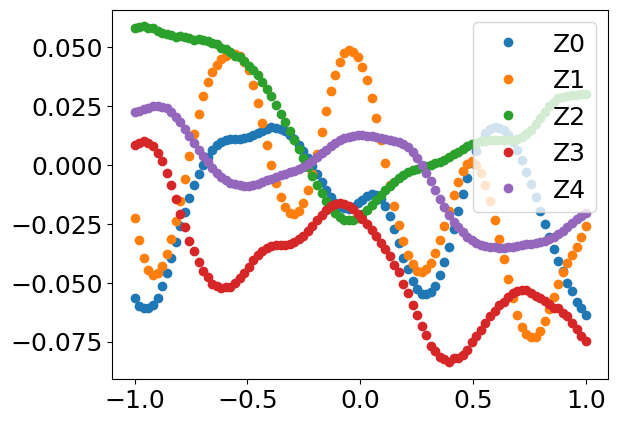

In [26]:
plt.plot(x_times, z0_train_results,'o', label = 'Z0')
plt.plot(x_times, z1_train_results, 'o',label = 'Z1')
plt.plot(x_times, z2_train_results, 'o',label = 'Z2')
plt.plot(x_times, z3_train_results, 'o',label = 'Z3')
plt.plot(x_times, z4_train_results, 'o',label = 'Z4')
plt.legend()

Now, we generate the quantum circuit for approximation

In [27]:
########  Parameter  #############
nqubit = 6 ## number of qubit
c_depth = 8 ## depth of circuit
time_step = 300 ## elapsed time of time evolution with random Hamiltonian

As in the previous exampples we will need to encode the input x parametrizing time in this case. So we create the gate $U_{in}(x_i)$ for embedding the input value $x_i$ in the initial state $\ket{00...0}$. According to reference $[1]$ we define:
$U_{in}(x_i) = $
with rotation gates
$R^Y_j$

So input $x_i$, is converted into: $\ket{\psi_{in}(x_i)} = U_{in}(x_i)\ket{00...0}$


[-2.97710295e-02-9.92053378e-01j  4.97397360e-02-9.94943968e-04j
  4.97397360e-02-9.94943968e-04j  2.49373430e-05+2.49360961e-03j
  4.97397360e-02-9.94943968e-04j  2.49373430e-05+2.49360961e-03j
  2.49373430e-05+2.49360961e-03j -1.25000000e-04+1.35525272e-20j
  4.97397360e-02-9.94943968e-04j  2.49373430e-05+2.49360961e-03j
  2.49373430e-05+2.49360961e-03j -1.25000000e-04+1.35525272e-20j
  2.49373430e-05+2.49360961e-03j -1.25000000e-04-1.35525272e-20j
 -1.25000000e-04-1.35525272e-20j  6.26570362e-08-6.26539032e-06j
  4.97397360e-02-9.94943968e-04j  2.49373430e-05+2.49360961e-03j
  2.49373430e-05+2.49360961e-03j -1.25000000e-04+2.71050543e-20j
  2.49373430e-05+2.49360961e-03j -1.25000000e-04-2.71050543e-20j
 -1.25000000e-04-2.71050543e-20j  6.26570362e-08-6.26539032e-06j
  2.49373430e-05+2.49360961e-03j -1.25000000e-04+0.00000000e+00j
 -1.25000000e-04+0.00000000e+00j  6.26570362e-08-6.26539032e-06j
 -1.25000000e-04+0.00000000e+00j  6.26570362e-08-6.26539032e-06j
  6.26570362e-08-6.265390

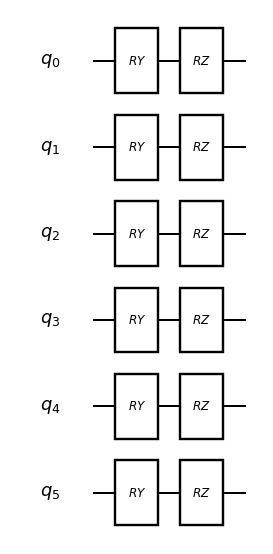

In [28]:
# Initial State
state = QuantumState(nqubit) # Initial state |000000>
state.set_zero_state()

# Function that creats a gate encoding x
def U_in(x):
    U = QuantumCircuit(nqubit)

    angle_y = np.arcsin(x)
    angle_z = np.arccos(x**2)

    for i in range(nqubit):
        U.add_RY_gate(i, angle_y)
        U.add_RZ_gate(i, angle_z)

    return U

# Test initial state
x = 0.1 # appropriate value
U_in(x).update_quantum_state(state) # calculation of U_in|000>
print(state.get_vector())

circuit_drawer(U_in(x),'mpl')

With the input value codificated into the quantum state, we construct the variational quantum circuit in the same way that we did for the one dimensional fit of $\sin(x)$

In [29]:
## Basic gate
from qulacs.gate import X, Z
I_mat = np.eye(2, dtype=complex)
X_mat = X(0).get_matrix() # applied to qubit 0
Z_mat = Z(0).get_matrix() # applied to qubit 0

## Function that creates fullsize gate.
def make_fullgate(list_SiteAndOperator, nqubit):
    '''
    Take list_SiteAndOperator = [ [i_0, O_0], [i_1, O_1], ...],
    Insert Identity into unrelated qubit
    make (2**nqubit, 2**nqubit) matrix:
    I(0) * ... * O_0(i_0) * ... * O_1(i_1) ...
    '''
    list_Site = [SiteAndOperator[0] for SiteAndOperator in list_SiteAndOperator]
    list_SingleGates = [] ## Arrange 1-qubit gates and reduce with np.kron
    cnt = 0
    for i in range(nqubit):
        if (i in list_Site):
            list_SingleGates.append( list_SiteAndOperator[cnt][1] )
            cnt += 1
        else: ## an empty site is identity
            list_SingleGates.append(I_mat)

    return reduce(np.kron, list_SingleGates)



#### Create time evolution operator by making random magnetic field and random coupling Ising Hamiltonian
ham = np.zeros((2**nqubit,2**nqubit), dtype = complex)
for i in range(nqubit): ## i runs 0 to nqubit-1
    Jx = -1. + 2.*np.random.rand() ## random number in -1~1
    ham += Jx * make_fullgate( [ [i, X_mat] ], nqubit)
    for j in range(i+1, nqubit):
        J_ij = -1. + 2.*np.random.rand()
        ham += J_ij * make_fullgate ([ [i, Z_mat], [j, Z_mat]], nqubit)

## Create a time evolution operator by diagonalization. H*P = P*D <-> H = P*D*P^dagger
diag, eigen_vecs = np.linalg.eigh(ham)
time_evol_op = np.dot(np.dot(eigen_vecs, np.diag(np.exp(-1j*time_step*diag))), eigen_vecs.T.conj()) # e^-iHT

# Convert to qulacs gate
from qulacs.gate import DenseMatrix
time_evol_gate = DenseMatrix([i for i in range(nqubit)], time_evol_op)

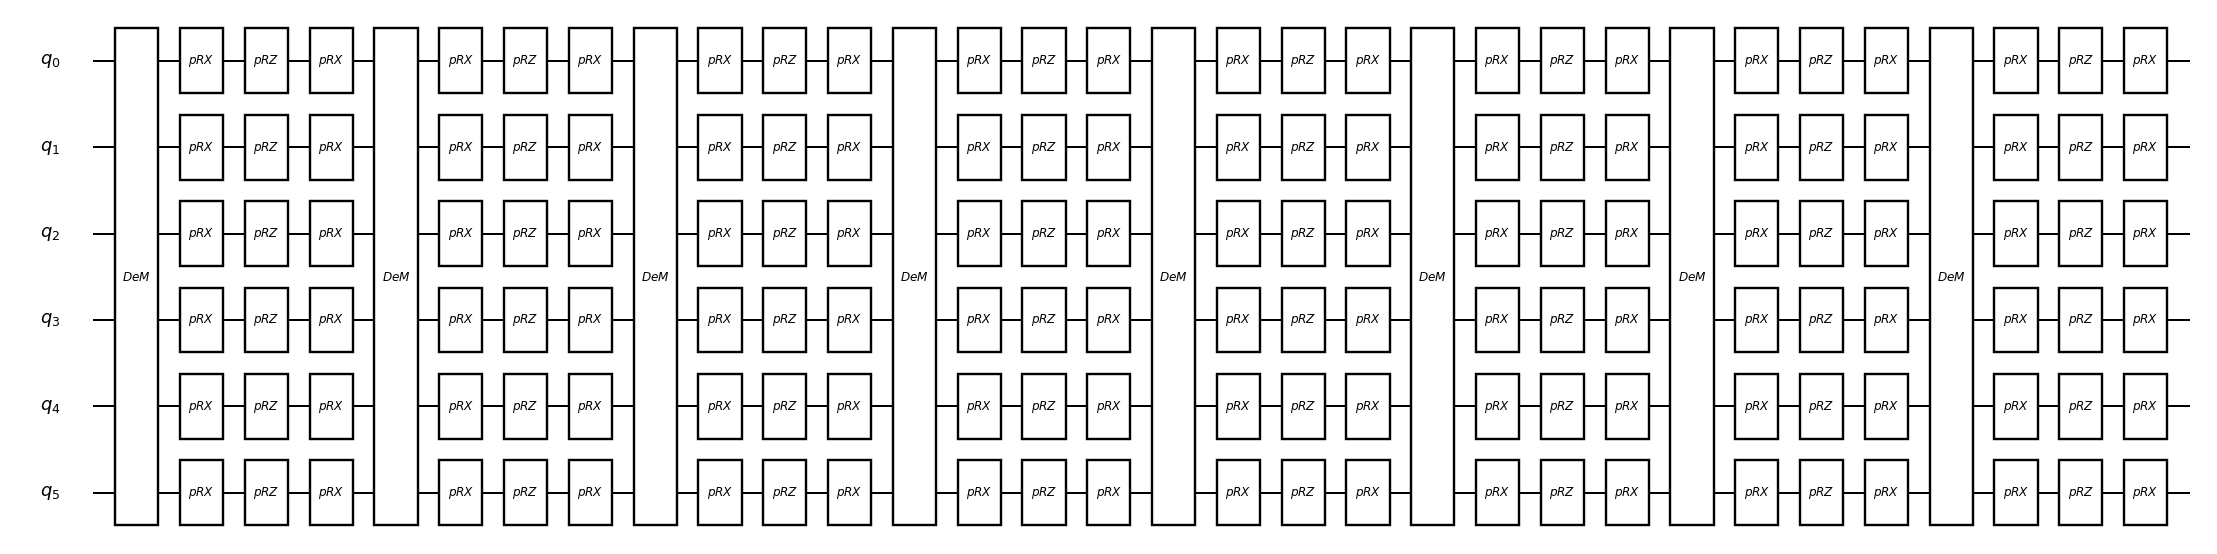

In [30]:
from qulacs import ParametricQuantumCircuit

# Assemble output gate U_out & set initial parameter values
U_out = ParametricQuantumCircuit(nqubit)
for d in range(c_depth):
    U_out.add_gate(time_evol_gate)
    for i in range(nqubit):
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RZ_gate(i,angle)
        angle = 2.0 * np.pi * np.random.rand()
        U_out.add_parametric_RX_gate(i,angle)

# Get the list of initial values of the parameter theta
parameter_count = U_out.get_parameter_count()
theta_init = [U_out.get_parameter(ind) for ind in range(parameter_count)]
circuit_drawer(U_out,'mpl')

In [31]:
# Function that updates parameter theta
def set_U_out(theta):
    global U_out

    parameter_count = U_out.get_parameter_count()

    for i in range(parameter_count):
        U_out.set_parameter(i, theta[i])

### Measurement

We now define the operators to measure the expectation values of the circuit qubits

In [32]:
z0 = Observable(nqubit)
z0.add_operator(1.,'Z 0') # a = 1

z1 = Observable(nqubit)
z1.add_operator(1.,'Z 1') # a = 1

z2 = Observable(nqubit)
z2.add_operator(1.,'Z 2') # a = 1

z3 = Observable(nqubit)
z3.add_operator(1.,'Z 3') # a = 1

z4 = Observable(nqubit)
z4.add_operator(1.,'Z 4') # a = 1

def get_output(state):

    z0_val = z0.get_expectation_value(state)
    z1_val = z1.get_expectation_value(state)
    z2_val = z2.get_expectation_value(state)
    z3_val = z3.get_expectation_value(state)
    z4_val = z4.get_expectation_value(state)
    
    return np.asarray([z0_val, z1_val, z2_val,z3_val,z4_val])

In [33]:
# Function that gives prediction value y(x_i, theta) of the model from input x_i
def qcl_pred(x, U_out):
    state = QuantumState(nqubit)
    state.set_zero_state()

    # Calculate input state
    U_in(x).update_quantum_state(state)

    # Calculate output state
    U_out.update_quantum_state(state)

    # Output of the model
    res = get_output(state)

    return res

In [34]:
def quadratic_loss(y_true, y_pred):
    return np.mean((np.array(y_true) - np.array(y_pred))**2)

In [35]:
# Calculate cost function L
def cost_func(theta):
    '''
    theta: ndarray of length c_depth * nqubit * 3
    '''
    # update the parameter theta of U_out
    # global U_out
    set_U_out(theta)

    # calculate basing on data of num_x_train in total
    y_pred = [qcl_pred(x, U_out) for x in x_times]

    # quadratic loss
    L = quadratic_loss(train_results, y_pred)

    return L

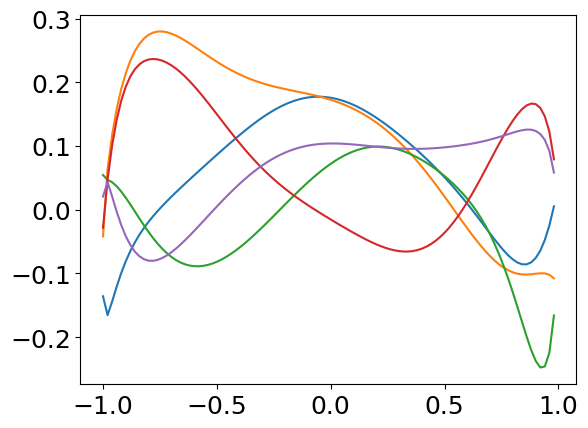

In [36]:
# Figure basing on inital parameter theta
xlist = np.arange(-1, 1, 0.02)
y_init = [qcl_pred(x, U_out) for x in xlist]
plt.plot(xlist, y_init)

In [37]:
from scipy.optimize import minimize
result = minimize(cost_func, theta_init, method='BFGS')

In [38]:
# Solution of theta by optimization
theta_opt = result.x
print(result.fun)

8.02949067310347e-05


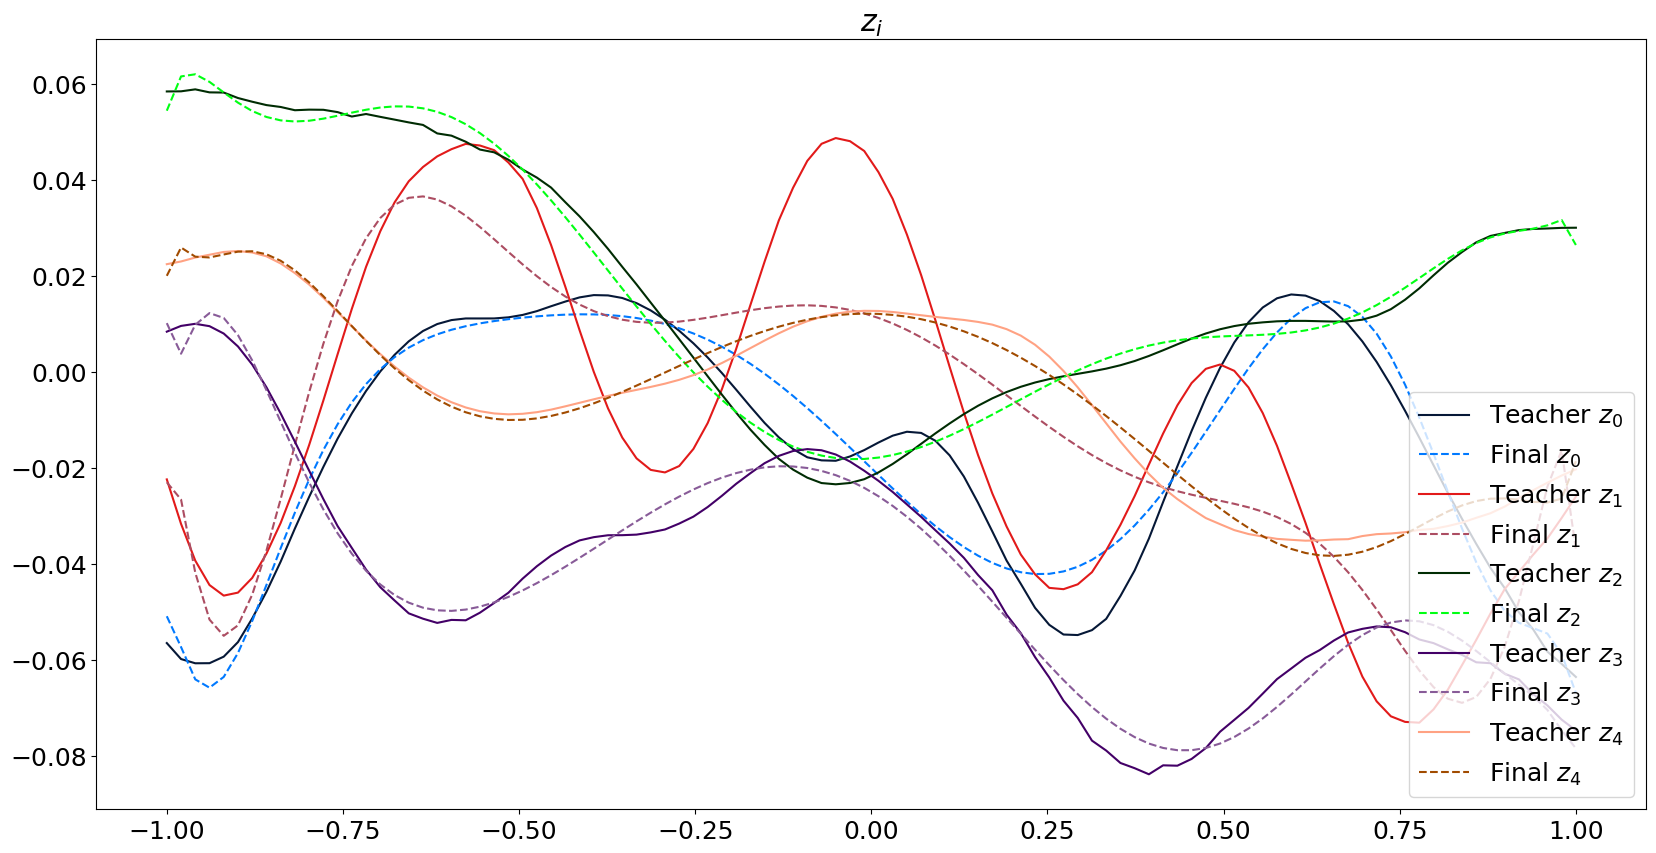

In [39]:
# Insert optimized theta into U_out
set_U_out(theta_opt)

# Create xlist
xlist = np.linspace(-1, 1, 100)

# Generate predictions
z_predictions = [np.array([qcl_pred(x, U_out)[i] for x in xlist]) for i in range(5)]

# Create a 2x3 subplot
fig, axs = plt.subplots(1, figsize=(20, 10))

# Darker shades

dark_colors = ['#061837', '#E21A1A', '#002C03', '#430067', '#FFA283']

# Lighter shades
light_colors = ['#0079FF', '#AC4D62', '#00FF13', '#885B98', '#A14B00']


# Plot individual quantities
for i in range(5):
    axs.plot(x_times, [step[i] for step in train_results], label='Teacher $z_{}$'.format(i), color=dark_colors[i])
    axs.plot(xlist, z_predictions[i], label=f'Final $z_{i}$', linestyle='--', color=light_colors[i])
    axs.legend(loc='lower right')
    axs.set_title(f'$z_i$')


plt.show()

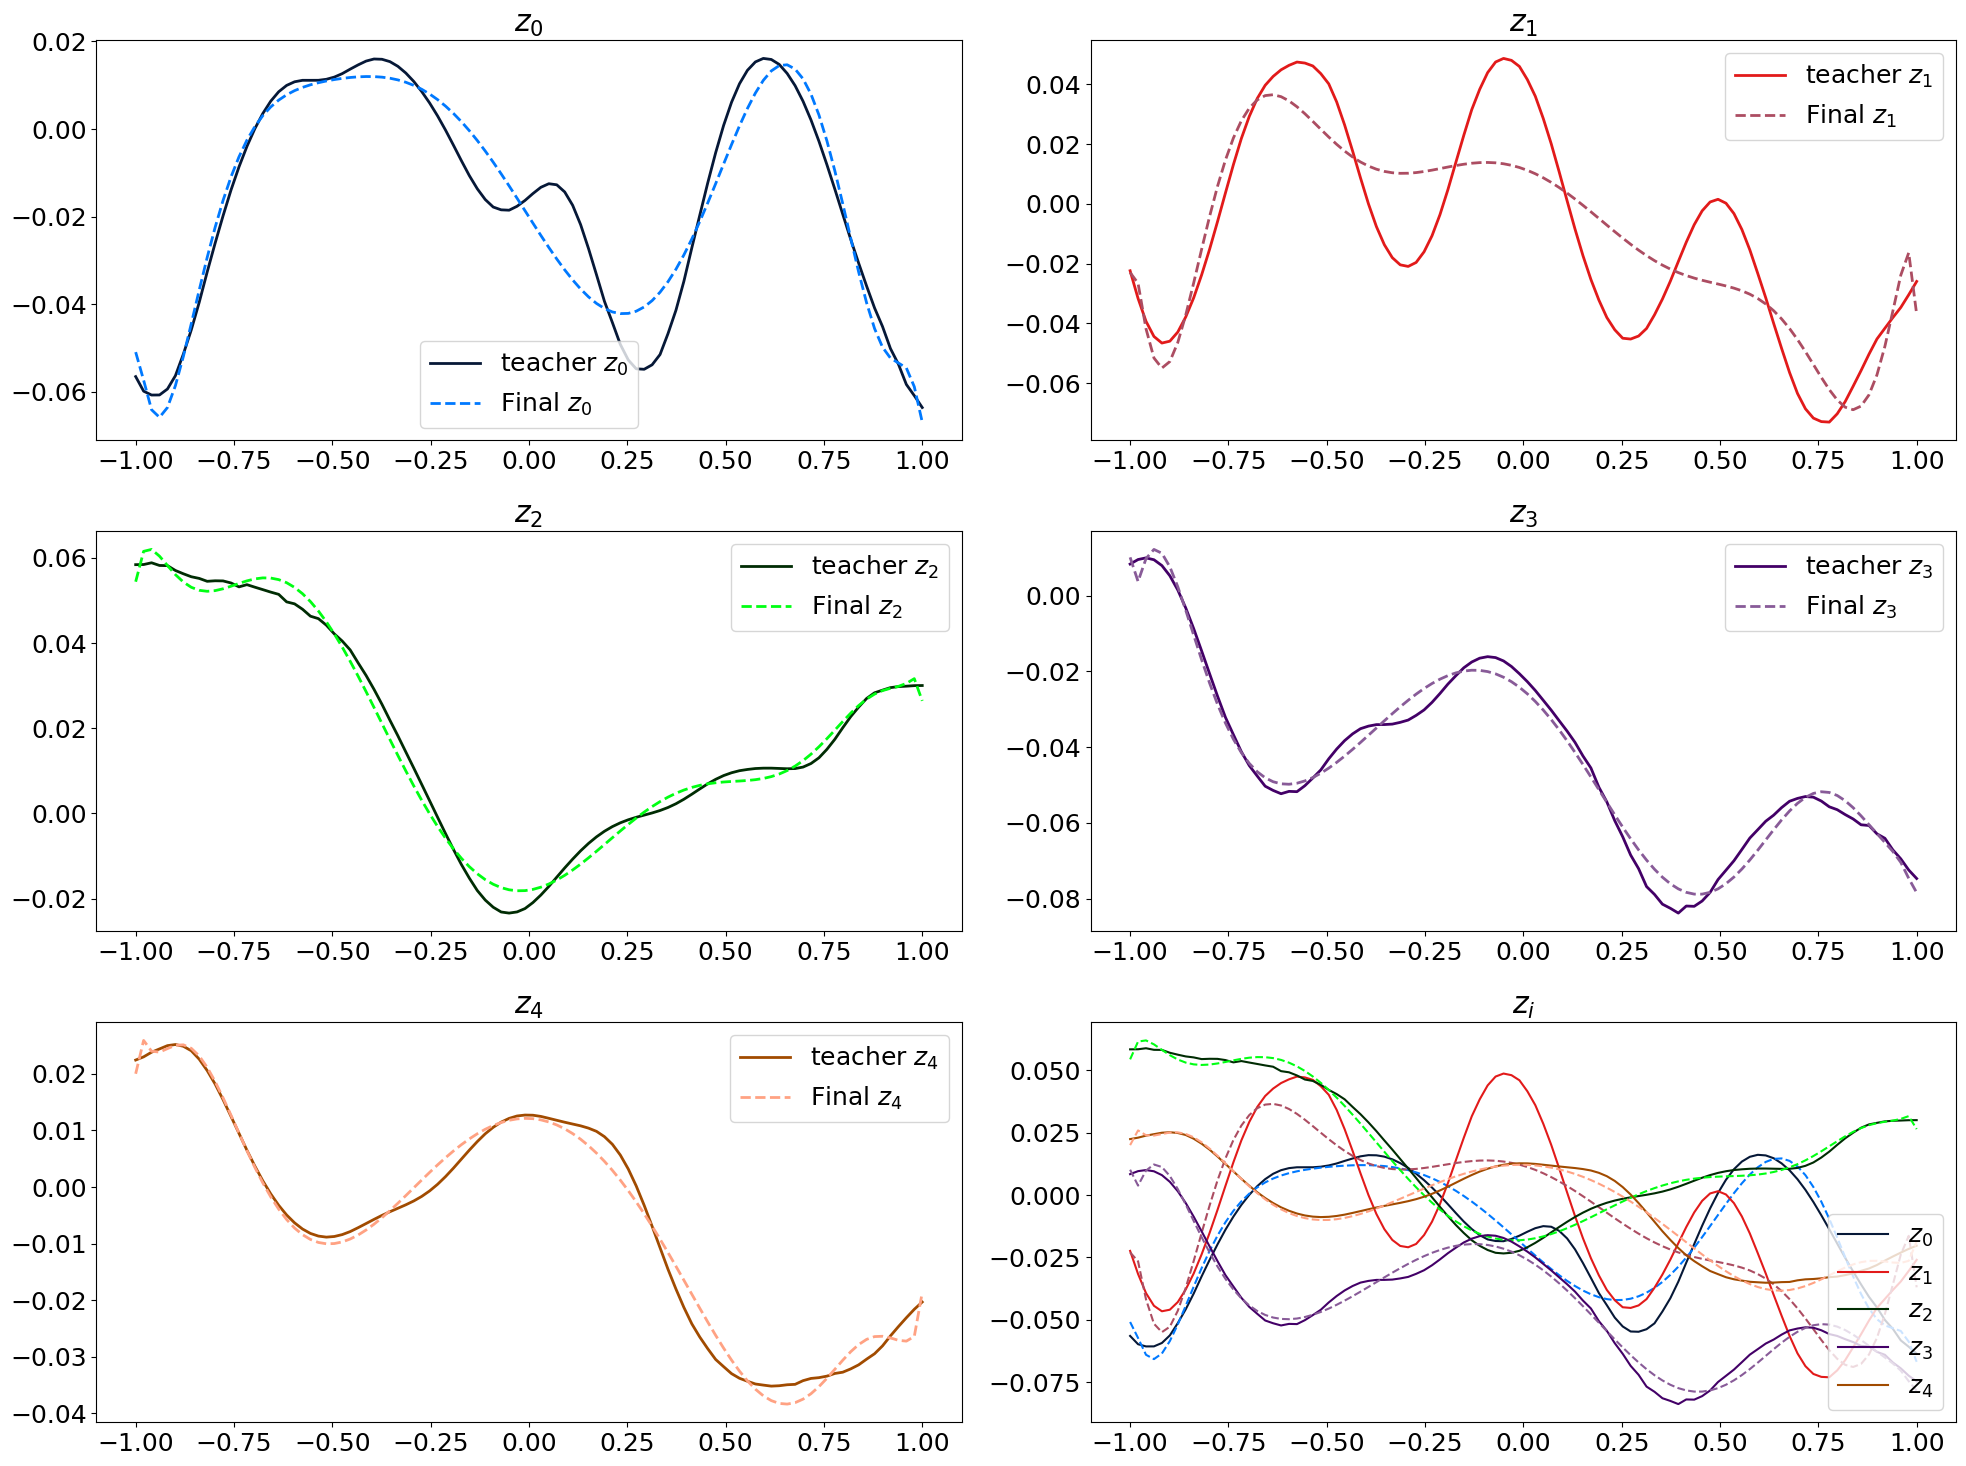

In [40]:
# Insert optimized theta into U_out
set_U_out(theta_opt)

# Create xlist
xlist = np.linspace(-1, 1, 100)

# Generate predictions
z_predictions = [np.array([qcl_pred(x, U_out)[i] for x in xlist]) for i in range(5)]

# Create a 3x2 subplot
fig, axs = plt.subplots(3, 2, figsize=(20,15))


# Darker shades
dark_colors = ['#061837', '#E21A1A', '#002C03', '#430067', '#A14B00']

# Lighter shades
light_colors = ['#0079FF', '#AC4D62', '#00FF13', '#885B98', '#FFA283']

# Plot individual quantities
for i in range(4):
    axs[i//2, i%2].plot(x_times, [step[i] for step in train_results], label='teacher $z_{}$'.format(i), color=dark_colors[i], linewidth=2)
    axs[i//2, i%2].plot(xlist, z_predictions[i], label=f'Final $z_{i}$', linestyle='--', color=light_colors[i], linewidth=2)
    axs[i//2, i%2].legend()
    axs[i//2, i%2].set_title(f'$z_{i}$', )

# Plot z4 in the third row
axs[2, 0].plot(x_times, [step[4] for step in train_results], label='teacher $z_4$', color=dark_colors[4], linewidth=2)
axs[2, 0].plot(xlist, z_predictions[4], label='Final $z_4$', linestyle='--', color=light_colors[4], linewidth=2)
axs[2, 0].legend()
axs[2, 0].set_title('$z_4$')

# Plot all together in the last subplot
for i in range(5):
    axs[2, 1].plot(x_times, [step[i] for step in train_results], label='$z_{}$'.format(i), color=dark_colors[i])
    axs[2,1].plot(xlist, z_predictions[i], linestyle='--', color=light_colors[i])
    axs[2,1].legend(loc='lower right')
    axs[2,1].set_title(f'$z_i$')

plt.tight_layout()
plt.show()
